In [1]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import threading
import queue
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
BATCH_SIZE=64
EPOCHS = 25
VAL_SPLIT = 0.85
DROPOUT_RATE = 0.3

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#(y_train, y_test) = map(to_categorical, [y_train, y_test])
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
split = int(len(x_train)*VAL_SPLIT)
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
train_groups = [(x_train[np.where(y_train==i)[0]],i) for i in np.unique(y_train)]
val_groups = [(x_val[np.where(y_val==i)[0]],i)  for i in np.unique(y_val)]
test_groups = [(x_test[np.where(y_test==i)[0]],i)  for i in np.unique(y_train)]
print('train groups:', [x[0].shape[0] for x in train_groups])
print('val groups:', [x[0].shape[0] for x in val_groups])
print('test groups:', [x[0].shape[0] for x in test_groups])

train groups: [5070, 5124, 5101, 5083, 5038, 5107, 5128, 5151, 5128, 5070]
val groups: [930, 876, 899, 917, 962, 893, 872, 849, 872, 930]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [0]:
class GroupLoader:
  def __init__(self, group, shuffle=True):
    self.x = np.asarray(group)
    self.len = len(self.x)
    self.index = 0
    self.shuffle = shuffle
  
  def __len__(self):
    return self.len
  
  def get(self, count):
    if self.index + count > self.len:
      self.index = 0
      if self.shuffle:
        np.random.shuffle(self.x)
    batch_x = self.x[self.index:self.index+count]
    self.index += count
    return batch_x
     

In [0]:
class DatasetLoader:
  def __init__(self, dataset, batch_size=BATCH_SIZE, shuffle=True):
    self.data = {y:GroupLoader(x, shuffle) for x,y in dataset}
    self.keys = np.asarray([int(x) for x in self.data.keys()])
    self.batch_size = batch_size
    self.out_shape = (self.batch_size, 28,28,1)
    
  def __len__(self):
    return sum([len(x) for x in self.data.values()])//self.batch_size*3
  
  def get(self):
    anchor_keys = np.random.choice(self.keys, self.batch_size)
    negative_keys = np.random.choice(self.keys, self.batch_size)
    negative_keys[anchor_keys==negative_keys] +=1
    negative_keys[negative_keys==len(self.keys)] = 0
    anchor = np.asarray([self.data[key].get(1) for key in anchor_keys]).reshape(self.out_shape)
    positive = np.asarray([self.data[key].get(1) for key in anchor_keys]).reshape(self.out_shape)
    negative = np.asarray([self.data[key].get(1) for key in negative_keys]).reshape(self.out_shape)
    return anchor, positive, negative

    
  

In [0]:
class BackgroundDatasetLoader(threading.Thread, DatasetLoader):
  def __init__(self, dataset, batch_size=BATCH_SIZE, shuffle=True):
    DatasetLoader.__init__(self, dataset, batch_size, shuffle)
    threading.Thread.__init__(self)
    self.queue = queue.Queue(1)
    self.daemon = True
    self.start()
    
  def run(self):
    while True:
      self.queue.put(self.get())
    self.queue.put(None)

  def next(self):
    next_item = self.queue.get()
    if next_item is None:
      print('Queue is empty.')
      next_item = self.get()
      if next_item is None:
        raise StopIteration
    return next_item

In [8]:
train_loader = DatasetLoader(train_groups, BATCH_SIZE)
val_loader = DatasetLoader(val_groups, BATCH_SIZE)
test_loader = DatasetLoader(test_groups, BATCH_SIZE)

print(len(train_loader))

2388


In [0]:
class TrainTriplet:
  def __init__(self, loaders):
    self.train_loader, self.val_loader, self.test_loader = loaders
    self.build()
  
  def _euclidean_distance(self, first_input, second_input, name):
    return tf.reduce_sum(tf.square(first_input-second_input), axis=1, keepdims=True)#tf.sqrt(, name=name)

  def _triplet_loss(self, positive_distance, negative_distance):

    margin = 0.4
    loss = tf.reduce_mean(tf.maximum(0.0, positive_distance -
                                        negative_distance + margin), name='triplet_loss')  # , axis=0, keepdims=True
    return loss
  
  def __conv_block(self, x, filters, filter_size=(3,3), pool_size=(2,2), pool_strides=(2,2), activation=tf.nn.relu, reuse=False, name='conv_block_1_'):
    x = tf.layers.conv2d(x, filters, kernel_size=filter_size, activation=activation, padding='same', reuse=reuse, name=name+'conv1')
    x = tf.layers.conv2d(x, filters, kernel_size=filter_size, activation=activation, padding='same', reuse=reuse, name=name+'conv2')
    x = tf.layers.max_pooling2d(x, pool_size, pool_strides, padding='same', name=name+'mp')
    x = tf.layers.batch_normalization(x, reuse=reuse, name=name+'bn')
    x = tf.layers.dropout(x, self.dropout_rate, name=name+'dr')
    return x
    
  def __fc_block(self, x, units, activation=tf.nn.relu, reuse=False, name='fc_block_1_'):
    x = tf.layers.dense(x,units, activation=activation, reuse=reuse, name=name+'dense')
    x = tf.layers.batch_normalization(x, reuse=reuse, name=name+'bn')
    x = tf.layers.dropout(x, self.dropout_rate, name=name+'dr')
    return x
  
  def _siamese_model(self, input_tensor, reuse):
    with tf.name_scope('conv_blocks'):
      x = self.__conv_block(input_tensor, 32, reuse=reuse, name='conv_block_1_') 
      x = self.__conv_block(x, 64, reuse=reuse, name='conv_block_2_') 
      x = self.__conv_block(x, 128, reuse=reuse, name='conv_block_3_') 
      
    x = tf.layers.flatten(x)
    
    with tf.name_scope('fc_blocks'):
      x = self.__fc_block(x, 512, reuse=reuse, name='fc_block_1_')
    output = tf.layers.dense(x,128, activation=tf.nn.sigmoid, reuse=reuse, name='output')
    return output
  
  def build(self):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
      self.anchor = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='anchor_ph')
      self.positive = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='positive_ph')
      self.negative = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='negative_ph')
      self.lr = tf.placeholder_with_default(0.0002, [])    
      self.dropout_rate = tf.placeholder_with_default(1., [])
      
    with tf.name_scope('siamese'):
      self.anchor_output = self._siamese_model(self.anchor, False)
      self.positive_output = self._siamese_model(self.positive, True)
      self.negative_output = self._siamese_model(self.negative, True)
      
    with tf.name_scope('distances'):
      self.positive_distance = self._euclidean_distance(self.anchor_output, self.positive_output, 'positive_distance')      
      self.negative_distance = self._euclidean_distance(self.anchor_output, self.negative_output, 'negative_distance')

    with tf.name_scope('train'):
      self.loss = self._triplet_loss(self.positive_distance, self.negative_distance)
      self.accuracy = tf.div( (tf.reduce_sum(tf.cast(self.positive_distance<0.5, tf.float32)) +tf.reduce_sum(tf.cast(self.negative_distance>0.5, tf.float32)) ) 
                             , tf.cast(tf.shape(self.positive_distance)[0], tf.float32)*2.)
      self.train = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)

  def _eval(self, loader):
      total_loss=[]  
      total_acc=[]
      for step in range(len(loader)):
        a, p, n = loader.get()
        _loss, acc,  = self.sess.run([self.loss, self.accuracy], feed_dict={self.anchor: a, self.positive: p, self.negative:n})
        total_loss.append(_loss)
        total_acc.append(acc)
      loss = sum(total_loss)/len(total_loss)
      acc = sum(total_acc)/len(total_acc)
      return (loss, acc)

  def evaluate(self, data):
    return self.sess.run(self.anchor_output, feed_dict={self.anchor:data})
    
  def train_model(self, epochs=EPOCHS, lr=0.0002, decay=1.):
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())
    self.sess.run(tf.local_variables_initializer())
    for epoch in range(epochs):
      total_train_loss=[]  
      total_train_acc=[]
      for step in range(len(self.train_loader)):
        a, p, n = self.train_loader.get()
        _, _loss, _acc,  = self.sess.run([self.train, self.loss, self.accuracy], feed_dict={self.anchor: a, self.positive: p, self.negative:n ,self.lr:lr, self.dropout_rate:DROPOUT_RATE})
        total_train_loss.append(_loss)
        total_train_acc.append(_acc)

      lr *= decay
      val_loss, val_acc = self._eval(self.val_loader)
      print('epoch:',epoch+1,'  train loss:', sum(total_train_loss)/len(total_train_loss), ' train acc:',sum(total_train_acc)/len(total_train_acc) ,'  val loss:', val_loss, ' val acc:',val_acc, '  lr:', lr)
      
    test_loss, test_acc = self._eval(self.test_loader)
    print('test loss:', test_loss, ' test acc:',test_acc )
      

In [10]:
train = TrainTriplet((train_loader, val_loader, test_loader))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


In [11]:
train.train_model(2, 0.0002, 0.95)

epoch: 1   train loss: 0.051010998531043454  train acc: 0.8691733406616415   val loss: 0.03286897436261088  val acc: 0.88359375   lr: 0.00019
epoch: 2   train loss: 0.029907394339306316  train acc: 0.8897416771356784   val loss: 0.02667679379949169  val acc: 0.8862165178571428   lr: 0.0001805
test loss: 0.030859909447220463  test acc: 0.8828792735042735


In [0]:
def euclidean_distance(first_input, second_input):
  return np.sum(np.square(first_input-second_input), axis=1, keepdims=True)#tf.sqrt(, name=name)

In [0]:
a, p, n = test_loader.get()
a = a[:8]
p = p[:4]
n = n[4:8]
pn = np.concatenate((p,n), axis=0)
enc_a = train.evaluate(a)
enc_pn = train.evaluate(pn) 
dist = euclidean_distance(enc_a, enc_pn).reshape(-1)


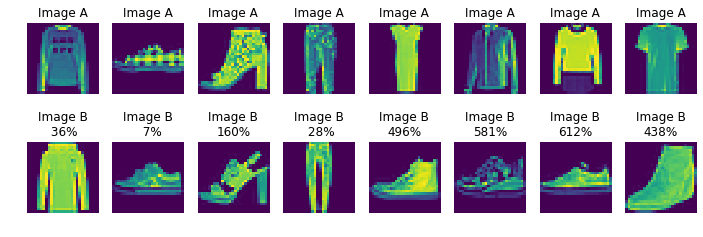

In [29]:
fig, m_axs = plt.subplots(2, a.shape[0], figsize = (12, 4))
for c_a, c_b, c_d, (ax1, ax2) in zip(a, pn, dist, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n%3.0f%%' % (c_d*100))
    ax2.axis('off')